<a href="https://colab.research.google.com/github/mishras/machine_learning/blob/master/GA_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  30 of 30 completed


Streaming output truncated to the last 5000 lines.
 0.00906238 0.01619367 0.00637109 0.00355246 0.04430818 0.01326343
 0.16519254 0.04423725 0.00607459 0.00552437 0.01074658 0.01535123
 0.00751961 0.00868883 0.14146474 0.02476535 0.00980403 0.0213377 ] and [0.01478266 0.35881741 0.004883   0.01116173 0.01022965 0.0031676
 0.0061119  0.00442957 0.01022482 0.01037747 0.01308172 0.01300698
 0.00889434 0.01599698 0.00625262 0.00348576 0.04348421 0.01362221
 0.16227885 0.0434146  0.00595451 0.00544331 0.01147295 0.01507197
 0.00737978 0.00853356 0.13363016 0.02431192 0.00955689 0.0209409 ] to produce child [0.01492272 0.35110037 0.0049292  0.0112079  0.01030207 0.00319761
 0.00616981 0.00447154 0.01033032 0.01047902 0.01316717 0.0131305
 0.00897836 0.01609532 0.00631186 0.00351911 0.04389619 0.01344282
 0.1637357  0.04382592 0.00601455 0.00548384 0.01110976 0.0152116
 0.0074497  0.00861119 0.13754745 0.02453863 0.00968046 0.0211393 ]
Crossover between parents [0.01478266 0.35881741 0.004883

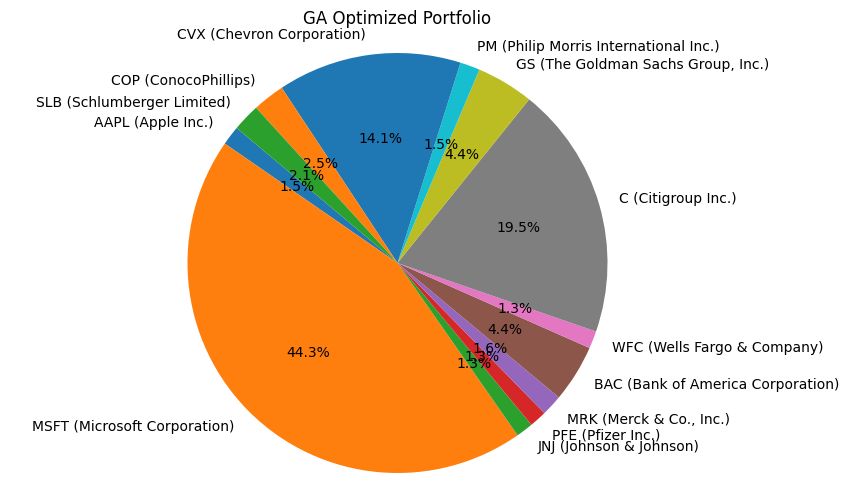

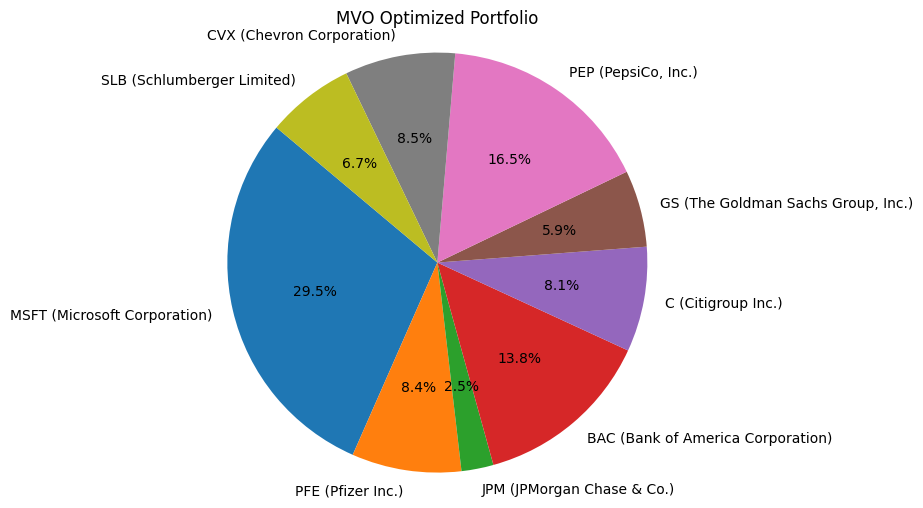

In [ ]:
# Install Required Libraries
!pip install numpy pandas yfinance cvxopt matplotlib

# Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import random
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# Define tickers for top companies in prominent sectors
sectors = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'ADBE', 'ORCL', 'CSCO'],
    'Healthcare': ['JNJ', 'PFE', 'UNH', 'MRK', 'ABBV'],
    'Finance': ['JPM', 'BAC', 'WFC', 'C', 'GS'],
    'Consumer Goods': ['PG', 'KO', 'PEP', 'PM', 'MO'],
    'Energy': ['XOM', 'CVX', 'COP', 'PSX', 'SLB']
}

# Flatten the list of tickers
tickers = [ticker for sector_tickers in sectors.values() for ticker in sector_tickers]

# Fetch Historical Data
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close']
returns = data.pct_change().dropna()

# Fetch full names of the stocks
stock_info = {ticker: yf.Ticker(ticker).info['longName'] for ticker in tickers}

# Calculate Mean Returns and Covariance Matrix
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

# Define Fitness Function for GA
def fitness_function(weights, returns, target_return):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - 0.01) / portfolio_volatility
    penalty = abs(portfolio_return - target_return)
    return sharpe_ratio - penalty

# Initialize population for GA
def initialize_population(pop_size, num_assets):
    population = []
    for _ in range(pop_size):
        individual = np.random.random(num_assets)
        individual /= np.sum(individual)  # Normalize weights to sum to 1
        population.append(individual)
    return population

# Select parents for GA
def selection(population, fitness_scores, num_parents):
    selected_indices = np.argsort(fitness_scores)[-num_parents:]
    selected = [population[i] for i in selected_indices]
    print(f"Selected parents based on fitness scores: {selected_indices}")
    return selected

# Crossover function for GA
def crossover(parents, num_offspring):
    offspring = []
    for _ in range(num_offspring):
        parent1, parent2 = random.sample(parents, 2)
        child = 0.5 * (parent1 + parent2)
        child /= np.sum(child)  # Normalize weights to sum to 1
        offspring.append(child)
        print(f"Crossover between parents {parent1} and {parent2} to produce child {child}")
    return offspring

# Mutation function for GA
def mutate(individual, mutation_rate, min_weight, max_weight):
    print(f"Original individual before mutation: {individual}")
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] += np.random.normal(0, 0.1)
            individual[i] = max(min_weight, min(individual[i], max_weight))
    individual /= np.sum(individual)  # Normalize weights to sum to 1
    print(f"Mutated individual: {individual}")
    return individual

# Genetic Algorithm function
def genetic_algorithm(returns, target_return, pop_size=100, num_generations=50, mutation_rate=0.01, num_parents=20, min_weight=0.01, max_weight=0.5):
    num_assets = returns.shape[1]
    population = initialize_population(pop_size, num_assets)

    for generation in range(num_generations):
        print(f"\nGeneration {generation + 1}")
        fitness_scores = [fitness_function(individual, returns, target_return) for individual in population]
        parents = selection(population, fitness_scores, num_parents)
        num_offspring = pop_size - num_parents
        offspring = crossover(parents, num_offspring)
        offspring = [mutate(child, mutation_rate, min_weight, max_weight) for child in offspring]
        population = parents + offspring

    fitness_scores = [fitness_function(individual, returns, target_return) for individual in population]
    best_individual = population[np.argmax(fitness_scores)]

    return best_individual

# Mean-Variance Optimization function
def mean_variance_optimization(mean_returns, cov_matrix, target_return, min_weight=0.01, max_weight=0.5):
    num_assets = len(mean_returns)

    P = matrix(cov_matrix.values)
    q = matrix(np.zeros(num_assets))

    # Constraints Gx <= h
    G = matrix(np.vstack((np.eye(num_assets) * -1, np.eye(num_assets))))
    h = matrix(np.hstack((np.zeros(num_assets), np.ones(num_assets) * max_weight)))

    # Constraints Ax = b
    A = matrix(np.vstack((np.ones((1, num_assets)), mean_returns.values)))
    b = matrix([1.0, target_return])

    sol = solvers.qp(P, q, G, h, A, b)

    weights = np.array(sol['x']).flatten()
    return weights

# Define the target return (higher target return for higher risk tolerance)
target_return = 0.25

# Run Genetic Algorithm
best_portfolio_ga = genetic_algorithm(returns, target_return)
print("\nGA Optimized Portfolio Weights:")
for ticker, weight in zip(tickers, best_portfolio_ga):
    print(f"{ticker} ({stock_info[ticker]}): {weight:.2f}")

portfolio_return_ga = np.sum(mean_returns * best_portfolio_ga)
portfolio_volatility_ga = np.sqrt(np.dot(best_portfolio_ga.T, np.dot(cov_matrix, best_portfolio_ga)))
sharpe_ratio_ga = (portfolio_return_ga - 0.01) / portfolio_volatility_ga

print(f"\nGA Portfolio Return: {portfolio_return_ga:.2f}")
print(f"GA Portfolio Volatility: {portfolio_volatility_ga:.2f}")
print(f"GA Sharpe Ratio: {sharpe_ratio_ga:.2f}")

# Run Mean-Variance Optimization
optimal_weights_mvo = mean_variance_optimization(mean_returns, cov_matrix, target_return)

print("\nMVO Optimized Portfolio Weights:")
for ticker, weight in zip(tickers, optimal_weights_mvo):
    print(f"{ticker} ({stock_info[ticker]}): {weight:.2f}")

portfolio_return_mvo = np.sum(mean_returns * optimal_weights_mvo)
portfolio_volatility_mvo = np.sqrt(np.dot(optimal_weights_mvo.T, np.dot(cov_matrix, optimal_weights_mvo)))
sharpe_ratio_mvo = (portfolio_return_mvo - 0.01) / portfolio_volatility_mvo

print(f"\nMVO Portfolio Return: {portfolio_return_mvo:.2f}")
print(f"MVO Portfolio Volatility: {portfolio_volatility_mvo:.2f}")
print(f"MVO Sharpe Ratio: {sharpe_ratio_mvo:.2f}")

# Compare Results
print("\nComparison:")
print(f"GA Sharpe Ratio: {sharpe_ratio_ga:.2f}")
print(f"MVO Sharpe Ratio: {sharpe_ratio_mvo:.2f}")

# Plot the portfolios
def plot_pie_chart(weights, title):
    labels = [ticker for ticker, weight in zip(tickers, weights) if weight > 0.01]
    sizes = [weight for weight in weights if weight > 0.01]
    labels_full = [f"{ticker} ({stock_info[ticker]})" for ticker in labels]

    plt.figure(figsize=(10, 6))
    plt.pie(sizes, labels=labels_full, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Plot GA Portfolio
plot_pie_chart(best_portfolio_ga, "GA Optimized Portfolio")

# Plot MVO Portfolio
plot_pie_chart(optimal_weights_mvo, "MVO Optimized Portfolio")
